In [29]:
import datetime
import pandas as pd 
import numpy as np 
import os
import glob 
import matplotlib.pyplot as plt

In [15]:
files = glob.glob('*.csv')
to_keep = []
for file in files: 
    name = os.path.basename(file).replace(".csv", "")
    data = pd.read_csv(file)
    data.index = [datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in data['date']]
    data_series = data['close'].to_frame(name = name)
    to_keep += [data_series]
pd.concat(to_keep, axis = 1).to_pickle(r'stock_prices.pkl')
pd.concat(to_keep, axis = 1).to_csv(r'stock_prices.csv')


In [66]:
backtest_start_date = datetime.date(2004, 8, 19)
backtest_end_date = datetime.date(2022, 8, 19)
start_date = datetime.date(2022, 8, 20)
end_date = datetime.date(2024, 11, 18)

In [16]:
prices = pd.read_pickle(r'stock_prices.pkl')

In [24]:
def compute_returns(prices): 
    return (prices - prices.shift(1)) / prices

In [25]:
def compute_moving_average(returns, window): 
    return returns.rolling(window).mean()

In [36]:
def compute_signal(returns, short_window, long_window): 
    short_ma = compute_moving_average(returns, short_window)
    long_ma = compute_moving_average(returns, long_window)
    difference = short_ma - long_ma
    signal = difference.map(lambda x: 1 if x > 0 else (0 if x == 0 else -1))
    return signal


In [32]:
def compute_position(signal, position_scale): 
    return signal * position_scale

In [33]:
def compute_strategy_returns(returns, positions): 
    return 1 + (returns * positions.shift(1)).sum(axis = 1)

In [38]:
def compute_strategy(prices, short_window, long_window, position_scale): 
    returns = compute_returns(prices)
    signal = compute_signal(returns, short_window, long_window)
    positions = compute_position(signal, position_scale)
    strategy_returns = compute_strategy_returns(returns, positions)

    all_days = strategy_returns.index

    level = 100
    all_levels = {all_days[0]: level}
    for day in all_days[1:]: 
        level *= strategy_returns[day]
        all_levels[day] = level
    return pd.Series(all_levels)

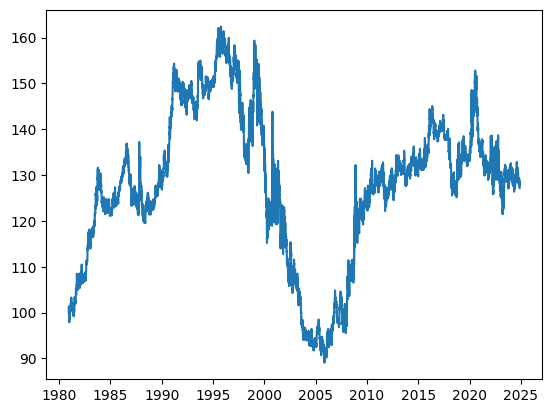

In [39]:
short_window = 25
long_window = 252
position_scale = 0.1
levels = compute_strategy(prices, short_window, long_window, position_scale)
plt.plot(levels)
plt.show()

In [49]:
def sharpe_ratio(levels): 
    returns = np.log(levels).diff()
    volatility = returns.std() * np.sqrt(252)
    return returns.mean() * 252/ volatility

In [58]:
def max_drawdown(levels): 
    level_list = levels.tolist()
    i = np.argmax(np.maximum.accumulate(level_list) - level_list) # end of the period
    j = np.argmax(level_list[:i]) # start of period
    min = level_list[i]
    max = level_list[j]
    return (max - min)/max * 100

In [72]:
short_window_options = [5, 10, 25, 50]
long_window_options = [50, 100, 252, 500]
position_scale_options = [0.05, 0.1, 0.2]
records = {}
max_sr = -10
max_key = None
for short in short_window_options:
    for long in long_window_options:
        for scale in position_scale_options:
            levels = compute_strategy(prices.loc[:backtest_end_date], short, long, scale)
            sharpe = sharpe_ratio(levels)
            mdd = max_drawdown(levels)
            records[(short, long, scale)] = [sharpe, mdd]
            if sharpe > max_sr: 
                max_sr = sharpe
                max_key = (short, long, scale)
records


{(5, 50, 0.05): [0.05344342463471354, 14.78104856775133],
 (5, 50, 0.1): [0.03194930169609234, 28.026745814233106],
 (5, 50, 0.2): [-0.011013533476629865, 50.03116668676946],
 (5, 100, 0.05): [0.09079223181236898, 15.80590239978652],
 (5, 100, 0.1): [0.0694454213024536, 29.476813601408857],
 (5, 100, 0.2): [0.02675974919472783, 51.90883434322525],
 (5, 252, 0.05): [-0.010475177621417583, 19.48322262346809],
 (5, 252, 0.1): [-0.03205765940691439, 36.97012795260706],
 (5, 252, 0.2): [-0.07517431367809309, 66.3399705560295],
 (5, 500, 0.05): [-0.07200538028266092, 22.963748902432012],
 (5, 500, 0.1): [-0.09372863424816268, 43.43755893987216],
 (5, 500, 0.2): [-0.137092818139181, 73.94440740626624],
 (10, 50, 0.05): [0.06043352492403049, 17.224807761197848],
 (10, 50, 0.1): [0.03882308690223484, 33.1829294089641],
 (10, 50, 0.2): [-0.004374831171284982, 59.6348682395326],
 (10, 100, 0.05): [0.07213004341420308, 16.005016408862975],
 (10, 100, 0.1): [0.05054905438741238, 30.584165218912307]

In [65]:
backtest_top = (25, 100, 0.05)

In [83]:
print(max_sr)
print(max_key)
print(max_sr_a)
print(max_key_a)

0.19326638887970282
(25, 50, 0.05)
0.7812763358535192
(50, 100, 0.05)


In [82]:
short_window_options = [5, 10, 25, 50]
long_window_options = [70 ,100, 252, 500]
position_scale_options = [0.05, 0.1, 0.2]
records = {}
max_sr_a = -10
max_key_a = None
for short in short_window_options:
    for long in long_window_options:
        for scale in position_scale_options:
            levels = compute_strategy(prices.loc[start_date:], short, long, scale)
            sharpe_a = sharpe_ratio(levels)
            mdd = max_drawdown(levels)
            records[(short, long, scale)] = [sharpe, mdd]
            if sharpe_a > max_sr_a: 
                max_sr_a = sharpe_a
                max_key_a = (short, long, scale)
records


{(5, 70, 0.05): [-0.013182385048881747, 7.819250396431686],
 (5, 70, 0.1): [-0.013182385048881747, 15.228682096709512],
 (5, 70, 0.2): [-0.013182385048881747, 28.821634376118993],
 (5, 100, 0.05): [-0.013182385048881747, 7.344987462319093],
 (5, 100, 0.1): [-0.013182385048881747, 14.259464468573865],
 (5, 100, 0.2): [-0.013182385048881747, 26.8589232857553],
 (5, 252, 0.05): [-0.013182385048881747, 8.76737477202809],
 (5, 252, 0.1): [-0.013182385048881747, 16.969490409218842],
 (5, 252, 0.2): [-0.013182385048881747, 31.73250492980501],
 (5, 500, 0.05): [-0.013182385048881747, 13.90551491601929],
 (5, 500, 0.1): [-0.013182385048881747, 26.101913817234905],
 (5, 500, 0.2): [-0.013182385048881747, 46.050220913876515],
 (10, 70, 0.05): [-0.013182385048881747, 3.1208825622482164],
 (10, 70, 0.1): [-0.013182385048881747, 6.279447540790728],
 (10, 70, 0.2): [-0.013182385048881747, 12.6683957921255],
 (10, 100, 0.05): [-0.013182385048881747, 4.797824739053624],
 (10, 100, 0.1): [-0.01318238504

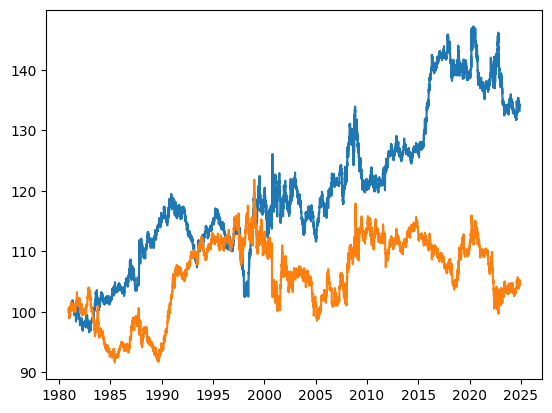

In [84]:
levels_backtest = compute_strategy(prices, 25, 50, 0.05)
levels_forward = compute_strategy(prices, 50, 100, 0.05)
plt.plot(levels_backtest)
plt.plot(levels_forward)
plt.show()